<a href="https://colab.research.google.com/github/ppiont/cnn-soc-wagga/blob/master/mlp_colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [17]:
pip install scikit-optimize

In [18]:
from google.colab import drive
drive.mount('/content/drive/')
%cd "/content/drive/MyDrive/Thesis/cnn-soc-wagga"

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).
/content/drive/MyDrive/Thesis/cnn-soc-wagga


In [19]:
# Standard lib imports
import os
import pathlib
import random

# Imports
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import KFold
from sklearn.linear_model import LinearRegression
from skopt import gp_minimize, dump, load
from skopt.space import Integer, Real, Categorical
from skopt.utils import use_named_args
from skopt.plots import plot_objective, plot_convergence, plot_evaluations
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
import copy
import pdb  # Brug det

In [20]:
# ------------------- TO DO ------------------------------------------------- #

"""
Use Torch Dataset.. you made a class for it dummy
"""

# ------------------- Settings ---------------------------------------------- #


# Set matploblib style
plt.style.use('seaborn-colorblind')
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
plt.rcParams['figure.dpi'] = 450
plt.rcParams['savefig.transparent'] = True
plt.rcParams['savefig.format'] = 'svg'

# Reset params if needed
# plt.rcParams.update(mpl.rcParamsDefault)


# ------------------- Organization ------------------------------------------ #


DATA_DIR = pathlib.Path('data/')


def seed_everything(SEED=43):
    random.seed(SEED)
    np.random.seed(SEED)
    torch.manual_seed(SEED)
    torch.cuda.manual_seed(SEED)
    torch.cuda.manual_seed_all(SEED)
    torch.backends.cudnn.deterministic = True
    os.environ['PYTHONHASHSEED']=str(SEED)
    torch.backends.cudnn.benchmark = False


SEED = 43
seed_everything(SEED=SEED)


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
torch.set_default_tensor_type('torch.cuda.FloatTensor')

In [21]:
# ------------------- Read and prep data ------------------------------------ #

train_data = np.load(DATA_DIR.joinpath('train_no_log.npy'))
test_data = np.load(DATA_DIR.joinpath('test_no_log.npy'))

x_train = train_data[:, 1:]
y_train = train_data[:, 0]

input_dims=x_train.shape[-1]

x_test = test_data[:, 1:]
y_test = test_data[:, 0]

# Normalize X
scaler_x = MinMaxScaler()
scaler_x.fit(x_train)
x_train = scaler_x.transform(x_train)
x_test = scaler_x.transform(x_test)

# Normalize y
scaler_y = MinMaxScaler()
scaler_y.fit(y_train.reshape(-1, 1))
y_train = scaler_y.fit_transform(y_train.reshape(-1, 1))
# There is no reason to scale y_test actually
y_test = scaler_y.transform(y_test.reshape(-1, 1))


x_train, y_train = torch.from_numpy(x_train), torch.from_numpy(y_train)
x_test, y_test = torch.from_numpy(x_test), torch.from_numpy(y_test)

x_train, x_test = x_train.to(device), x_test.to(device)
y_train, y_test = y_train.to(device), y_test.to(device)

class Dataset(torch.utils.data.TensorDataset):
    """Characterize a PyTorch Dataset."""

    def __init__(self, features, targets):
        """Initialize with X and y."""
        self.features = features
        self.targets = targets

    def __len__(self):
        """Return total number of samples."""
        return len(self.targets)

    def __getitem__(self, index):
        """Generate one data sample."""
        return self.features[index], self.targets[index]

In [22]:
# ------------------- NN setup ---------------------------------------------- #

class NeuralNet(nn.Module):
    """Neural Network class."""

    def __init__(self, input_dims=input_dims, n_layers=3, n_neurons=64,
                 activation=nn.ELU(), dropout_rate=0.5):
        """Initialize as subclass of nn.Module, inherit its methods."""
        super(NeuralNet, self).__init__()

        self.input_dims = input_dims
        self.n_neurons = n_neurons
        self.n_layers = n_layers

        # Layer structure
        # First layer
        self.in_layer = nn.Linear(self.input_dims, self.n_neurons)

        # Dense, Dropout, Activation and BN
        self.dense = nn.Linear(self.n_neurons, self.n_neurons)
        self.dropout = nn.Dropout(p=dropout_rate)
        self.activation = activation
        self.batchnorm = nn.BatchNorm1d(self.n_neurons)

        # Output layer
        self.out_layer = nn.Linear(self.n_neurons, 1)

    def forward(self, x):
        """Forward pass."""
                
        x = self.batchnorm(self.activation(self.dropout(self.in_layer(x))))

        for i in range(self.n_layers-1):
            x = self.batchnorm(self.activation(self.dropout(self.dense(x))))

        x = self.out_layer(x)

        return x


def train_step(model, features, targets, optimizer, loss_fn):
    """Perform a single training step.

    Calulcates prediction, loss and gradients for a single batch
    and updates optimizer parameters accordingly."""

    # Set gradients to zero
    model.zero_grad()
    # Pass data through model
    output = model(features)
    # Calculate loss
    loss = loss_fn(output, targets)
    # Calculate gradients
    loss.backward()
    # Update parameters
    optimizer.step()

    return loss, output


def train_network(model, train_data, val_data, optimizer, loss_fn,
                  n_epochs=2000, patience=100, print_progress=True):
    """Train a neural network model."""
    # Initalize loss as very high
    best_loss = 1e8

    # Create lists to hold train and val losses
    train_loss = []
    val_loss = []
    # Init epochs_no_improve
    epochs_no_improve = 0
    best_model = copy.deepcopy(model.state_dict())
    
    # Start training (loop over epochs)
    for epoch in range(n_epochs):

        # Initalize epoch train loss
        train_epoch_loss = 0
        # Loop over training batches
        model.train()  # set model to training mode for training
        for bidx, (features, targets) in enumerate(train_data):
            # Calculate loss and predictions
            loss, predictions = train_step(model, features, targets,
                                           optimizer, loss_fn)
            train_epoch_loss += loss
        # Save train epoch loss
        train_loss.append(train_epoch_loss.item())

        # Initialize val epoch loss
        val_epoch_loss = 0
        # Loop over validation batches
        model.eval()  # set model to evaluation mode for validation
        for bidx, (features, targets) in enumerate(val_data):
            output = model(features)
            val_epoch_loss += loss_fn(output, targets)
        # Save val epoch loss
        val_loss.append(val_epoch_loss.item())

        # Early stopping (check if val loss is an improvement on current best)
        if val_epoch_loss < best_loss:
            best_loss = val_epoch_loss.item()
            best_model = copy.deepcopy(model.state_dict())
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1

            # Check early stopping condition
            if epochs_no_improve == patience:
                print(f'Stopping after {epoch} epochs due to no improvement.')
                model.load_state_dict(best_model)
                break
        # Print progress at set epoch intervals if desired
        if print_progress:
            if (epoch + 1) % 100 == 0:
                print(f'Epoch {epoch+1} Train Loss: {train_epoch_loss:.4}, ', end='')
                print(f'Val Loss: {val_epoch_loss:.4}')

    return train_loss, val_loss


def weight_reset(m):
    """Reset all weights in an NN."""
    reset_parameters = getattr(m, "reset_parameters", None)
    if callable(reset_parameters):
        m.reset_parameters()

In [23]:
# ------------------- Cross-validation -------------------------------------- #

def kfold_cv_train(x_train, y_train, model, optimizer,loss_fn=nn.MSELoss(), 
                   n_splits=5, batch_size=312, n_epochs=2000, patience=100,
                   shuffle=True, rng=SEED):
    """Train a NN with K-Fold cross-validation."""
    kfold = KFold(n_splits=n_splits, shuffle=shuffle, random_state=rng)
    best_losses = []

    for fold, (train_index, val_index) in enumerate(kfold.split(x_train, y_train)):
        # print(f'Starting fold {fold + 1}')
        # Get training and val features
        x_train_fold = x_train[train_index]
        x_val_fold = x_train[val_index]

        # Get training and val targets
        y_train_fold = y_train[train_index]
        y_val_fold = y_train[val_index]

        train = Dataset(x_train_fold, y_train_fold)
        train_loader = DataLoader(train, batch_size=batch_size,
                                  shuffle=shuffle, drop_last=True)
        # Create val dataset and dataloader
        val = Dataset(x_val_fold, y_val_fold)
        val_loader = DataLoader(val, batch_size=batch_size,
                                shuffle=False, drop_last=False)

        # Train
        train_loss, val_loss = train_network(model=model,
                                             train_data=train_loader,
                                             val_data=val_loader,
                                             optimizer=optimizer,
                                             loss_fn=loss_fn,
                                             n_epochs=n_epochs,
                                             patience=patience,
                                             print_progress=False)
        best_losses.append(min(val_loss))
        model.apply(weight_reset)

    return sum(best_losses)/n_splits, train_loss, val_loss






Gaussian Process:   0%|          | 0/50 [00:00<?, ?it/s]

Iteration No: 1 started. Evaluating function at random point.
Stopping after 154 epochs due to no improvement.
Stopping after 123 epochs due to no improvement.
Stopping after 318 epochs due to no improvement.
Stopping after 332 epochs due to no improvement.







Gaussian Process:   2%|▏         | 1/50 [01:04<52:52, 64.74s/it]

Stopping after 392 epochs due to no improvement.
Iteration No: 1 ended. Evaluation done at random point.
Time taken: 64.7223
Function value obtained: 0.0366
Current minimum: 0.0366
Iteration No: 2 started. Evaluating function at random point.
Stopping after 267 epochs due to no improvement.
Stopping after 437 epochs due to no improvement.
Stopping after 467 epochs due to no improvement.
Stopping after 275 epochs due to no improvement.







Gaussian Process:   4%|▍         | 2/50 [03:07<1:05:40, 82.10s/it]

Stopping after 352 epochs due to no improvement.
Iteration No: 2 ended. Evaluation done at random point.
Time taken: 122.6093
Function value obtained: 0.0385
Current minimum: 0.0366
Iteration No: 3 started. Evaluating function at random point.
Stopping after 165 epochs due to no improvement.
Stopping after 170 epochs due to no improvement.
Stopping after 295 epochs due to no improvement.
Stopping after 203 epochs due to no improvement.







Gaussian Process:   6%|▌         | 3/50 [04:16<1:01:18, 78.27s/it]

Stopping after 191 epochs due to no improvement.
Iteration No: 3 ended. Evaluation done at random point.
Time taken: 69.3381
Function value obtained: 0.0381
Current minimum: 0.0366
Iteration No: 4 started. Evaluating function at random point.
Stopping after 116 epochs due to no improvement.
Stopping after 205 epochs due to no improvement.
Stopping after 195 epochs due to no improvement.
Stopping after 182 epochs due to no improvement.







Gaussian Process:   8%|▊         | 4/50 [04:40<47:24, 61.85s/it]  

Stopping after 133 epochs due to no improvement.
Iteration No: 4 ended. Evaluation done at random point.
Time taken: 23.5269
Function value obtained: 0.0190
Current minimum: 0.0190
Iteration No: 5 started. Evaluating function at random point.
Stopping after 189 epochs due to no improvement.
Stopping after 308 epochs due to no improvement.
Stopping after 259 epochs due to no improvement.
Stopping after 249 epochs due to no improvement.







Gaussian Process:  10%|█         | 5/50 [05:12<39:49, 53.11s/it]

Stopping after 173 epochs due to no improvement.
Iteration No: 5 ended. Evaluation done at random point.
Time taken: 32.7248
Function value obtained: 0.0208
Current minimum: 0.0190
Iteration No: 6 started. Evaluating function at random point.
Stopping after 133 epochs due to no improvement.
Stopping after 129 epochs due to no improvement.
Stopping after 194 epochs due to no improvement.
Stopping after 235 epochs due to no improvement.







Gaussian Process:  12%|█▏        | 6/50 [06:06<39:02, 53.24s/it]

Stopping after 171 epochs due to no improvement.
Iteration No: 6 ended. Evaluation done at random point.
Time taken: 53.5410
Function value obtained: 0.0567
Current minimum: 0.0190
Iteration No: 7 started. Evaluating function at random point.
Stopping after 228 epochs due to no improvement.
Stopping after 199 epochs due to no improvement.
Stopping after 141 epochs due to no improvement.
Stopping after 134 epochs due to no improvement.







Gaussian Process:  14%|█▍        | 7/50 [06:32<32:13, 44.96s/it]

Stopping after 310 epochs due to no improvement.
Iteration No: 7 ended. Evaluation done at random point.
Time taken: 25.6307
Function value obtained: 0.0145
Current minimum: 0.0145
Iteration No: 8 started. Evaluating function at random point.
Stopping after 271 epochs due to no improvement.
Stopping after 212 epochs due to no improvement.
Stopping after 265 epochs due to no improvement.
Stopping after 339 epochs due to no improvement.







Gaussian Process:  16%|█▌        | 8/50 [07:05<29:08, 41.63s/it]

Stopping after 171 epochs due to no improvement.
Iteration No: 8 ended. Evaluation done at random point.
Time taken: 33.8534
Function value obtained: 0.0133
Current minimum: 0.0133
Iteration No: 9 started. Evaluating function at random point.
Stopping after 188 epochs due to no improvement.
Stopping after 333 epochs due to no improvement.
Stopping after 141 epochs due to no improvement.
Stopping after 109 epochs due to no improvement.







Gaussian Process:  18%|█▊        | 9/50 [07:30<24:58, 36.56s/it]

Stopping after 228 epochs due to no improvement.
Iteration No: 9 ended. Evaluation done at random point.
Time taken: 24.7346
Function value obtained: 0.1673
Current minimum: 0.0133
Iteration No: 10 started. Evaluating function at random point.
Stopping after 153 epochs due to no improvement.
Stopping after 472 epochs due to no improvement.
Stopping after 121 epochs due to no improvement.
Stopping after 108 epochs due to no improvement.







Gaussian Process:  20%|██        | 10/50 [08:10<25:04, 37.62s/it]

Stopping after 635 epochs due to no improvement.
Iteration No: 10 ended. Evaluation done at random point.
Time taken: 40.0849
Function value obtained: 0.0167
Current minimum: 0.0133
Iteration No: 11 started. Evaluating function at random point.
Stopping after 162 epochs due to no improvement.
Stopping after 119 epochs due to no improvement.
Stopping after 528 epochs due to no improvement.
Stopping after 126 epochs due to no improvement.







Gaussian Process:  22%|██▏       | 11/50 [08:36<22:08, 34.06s/it]

Stopping after 152 epochs due to no improvement.
Iteration No: 11 ended. Evaluation done at random point.
Time taken: 25.7511
Function value obtained: 0.0136
Current minimum: 0.0133
Iteration No: 12 started. Evaluating function at random point.
Stopping after 255 epochs due to no improvement.
Stopping after 128 epochs due to no improvement.
Stopping after 107 epochs due to no improvement.
Stopping after 115 epochs due to no improvement.







Gaussian Process:  24%|██▍       | 12/50 [09:14<22:13, 35.09s/it]

Stopping after 115 epochs due to no improvement.
Iteration No: 12 ended. Evaluation done at random point.
Time taken: 37.4973
Function value obtained: 0.0315
Current minimum: 0.0133
Iteration No: 13 started. Evaluating function at random point.
Stopping after 211 epochs due to no improvement.
Stopping after 453 epochs due to no improvement.
Stopping after 274 epochs due to no improvement.
Stopping after 232 epochs due to no improvement.







Gaussian Process:  26%|██▌       | 13/50 [09:57<23:10, 37.57s/it]

Stopping after 354 epochs due to no improvement.
Iteration No: 13 ended. Evaluation done at random point.
Time taken: 43.3497
Function value obtained: 0.0156
Current minimum: 0.0133
Iteration No: 14 started. Evaluating function at random point.
Stopping after 152 epochs due to no improvement.
Stopping after 189 epochs due to no improvement.
Stopping after 261 epochs due to no improvement.
Stopping after 238 epochs due to no improvement.







Gaussian Process:  28%|██▊       | 14/50 [10:34<22:32, 37.56s/it]

Stopping after 392 epochs due to no improvement.
Iteration No: 14 ended. Evaluation done at random point.
Time taken: 37.5301
Function value obtained: 0.0157
Current minimum: 0.0133
Iteration No: 15 started. Evaluating function at random point.
Stopping after 178 epochs due to no improvement.
Stopping after 156 epochs due to no improvement.
Stopping after 259 epochs due to no improvement.
Stopping after 212 epochs due to no improvement.







Gaussian Process:  30%|███       | 15/50 [11:49<28:28, 48.81s/it]

Stopping after 259 epochs due to no improvement.
Iteration No: 15 ended. Evaluation done at random point.
Time taken: 75.0543
Function value obtained: 0.0364
Current minimum: 0.0133
Iteration No: 16 started. Evaluating function at random point.
Stopping after 187 epochs due to no improvement.
Stopping after 211 epochs due to no improvement.
Stopping after 184 epochs due to no improvement.
Stopping after 206 epochs due to no improvement.







Gaussian Process:  32%|███▏      | 16/50 [12:33<26:40, 47.08s/it]

Stopping after 368 epochs due to no improvement.
Iteration No: 16 ended. Evaluation done at random point.
Time taken: 43.0413
Function value obtained: 0.0282
Current minimum: 0.0133
Iteration No: 17 started. Evaluating function at random point.
Stopping after 159 epochs due to no improvement.
Stopping after 184 epochs due to no improvement.
Stopping after 217 epochs due to no improvement.
Stopping after 126 epochs due to no improvement.







Gaussian Process:  34%|███▍      | 17/50 [12:58<22:21, 40.66s/it]

Stopping after 241 epochs due to no improvement.
Iteration No: 17 ended. Evaluation done at random point.
Time taken: 25.6989
Function value obtained: 0.0172
Current minimum: 0.0133
Iteration No: 18 started. Evaluating function at random point.
Stopping after 286 epochs due to no improvement.
Stopping after 266 epochs due to no improvement.
Stopping after 173 epochs due to no improvement.
Stopping after 228 epochs due to no improvement.







Gaussian Process:  36%|███▌      | 18/50 [13:25<19:31, 36.62s/it]

Stopping after 159 epochs due to no improvement.
Iteration No: 18 ended. Evaluation done at random point.
Time taken: 27.1895
Function value obtained: 0.0149
Current minimum: 0.0133
Iteration No: 19 started. Evaluating function at random point.
Stopping after 133 epochs due to no improvement.
Stopping after 274 epochs due to no improvement.
Stopping after 182 epochs due to no improvement.
Stopping after 107 epochs due to no improvement.







Gaussian Process:  38%|███▊      | 19/50 [13:50<17:01, 32.94s/it]

Stopping after 243 epochs due to no improvement.
Iteration No: 19 ended. Evaluation done at random point.
Time taken: 24.3356
Function value obtained: 0.0206
Current minimum: 0.0133
Iteration No: 20 started. Evaluating function at random point.
Stopping after 112 epochs due to no improvement.
Stopping after 345 epochs due to no improvement.
Stopping after 109 epochs due to no improvement.
Stopping after 117 epochs due to no improvement.
Stopping after 420 epochs due to no improvement.







Gaussian Process:  40%|████      | 20/50 [14:27<17:09, 34.32s/it]

Iteration No: 20 ended. Evaluation done at random point.
Time taken: 37.5327
Function value obtained: 0.0166
Current minimum: 0.0133
Iteration No: 21 started. Searching for the next optimal point.
Stopping after 1158 epochs due to no improvement.
Stopping after 100 epochs due to no improvement.
Stopping after 100 epochs due to no improvement.
Stopping after 1293 epochs due to no improvement.
Stopping after 1237 epochs due to no improvement.







Gaussian Process:  42%|████▏     | 21/50 [15:44<22:47, 47.16s/it]

Iteration No: 21 ended. Search finished for the next optimal point.
Time taken: 77.1208
Function value obtained: 0.0189
Current minimum: 0.0133
Iteration No: 22 started. Searching for the next optimal point.
Stopping after 102 epochs due to no improvement.
Stopping after 1614 epochs due to no improvement.
Stopping after 100 epochs due to no improvement.
Stopping after 1470 epochs due to no improvement.
Stopping after 101 epochs due to no improvement.







Gaussian Process:  44%|████▍     | 22/50 [16:55<25:18, 54.24s/it]

Iteration No: 22 ended. Search finished for the next optimal point.
Time taken: 70.7770
Function value obtained: 0.0143
Current minimum: 0.0133
Iteration No: 23 started. Searching for the next optimal point.
Stopping after 100 epochs due to no improvement.
Stopping after 675 epochs due to no improvement.
Stopping after 528 epochs due to no improvement.
Stopping after 308 epochs due to no improvement.
Stopping after 410 epochs due to no improvement.







Gaussian Process:  46%|████▌     | 23/50 [17:47<24:08, 53.66s/it]

Iteration No: 23 ended. Search finished for the next optimal point.
Time taken: 52.2884
Function value obtained: 0.0127
Current minimum: 0.0127
Iteration No: 24 started. Searching for the next optimal point.
Stopping after 135 epochs due to no improvement.
Stopping after 247 epochs due to no improvement.
Stopping after 176 epochs due to no improvement.
Stopping after 284 epochs due to no improvement.
Stopping after 117 epochs due to no improvement.







Gaussian Process:  48%|████▊     | 24/50 [18:13<19:33, 45.15s/it]

Iteration No: 24 ended. Search finished for the next optimal point.
Time taken: 25.2925
Function value obtained: 0.0087
Current minimum: 0.0087
Iteration No: 25 started. Searching for the next optimal point.
Stopping after 100 epochs due to no improvement.
Stopping after 101 epochs due to no improvement.
Stopping after 102 epochs due to no improvement.
Stopping after 658 epochs due to no improvement.
Stopping after 650 epochs due to no improvement.







Gaussian Process:  50%|█████     | 25/50 [18:52<18:00, 43.23s/it]

Iteration No: 25 ended. Search finished for the next optimal point.
Time taken: 38.7531
Function value obtained: 0.0133
Current minimum: 0.0087
Iteration No: 26 started. Searching for the next optimal point.
Stopping after 162 epochs due to no improvement.
Stopping after 104 epochs due to no improvement.
Stopping after 155 epochs due to no improvement.
Stopping after 155 epochs due to no improvement.
Stopping after 123 epochs due to no improvement.







Gaussian Process:  52%|█████▏    | 26/50 [21:51<33:42, 84.25s/it]

Iteration No: 26 ended. Search finished for the next optimal point.
Time taken: 179.9791
Function value obtained: 0.1754
Current minimum: 0.0087
Iteration No: 27 started. Searching for the next optimal point.
Stopping after 111 epochs due to no improvement.
Stopping after 267 epochs due to no improvement.
Stopping after 120 epochs due to no improvement.
Stopping after 240 epochs due to no improvement.
Stopping after 242 epochs due to no improvement.







Gaussian Process:  54%|█████▍    | 27/50 [22:17<25:31, 66.59s/it]

Iteration No: 27 ended. Search finished for the next optimal point.
Time taken: 25.3683
Function value obtained: 0.0087
Current minimum: 0.0087
Iteration No: 28 started. Searching for the next optimal point.
Stopping after 637 epochs due to no improvement.
Stopping after 100 epochs due to no improvement.
Stopping after 1863 epochs due to no improvement.
Stopping after 103 epochs due to no improvement.







Gaussian Process:  56%|█████▌    | 28/50 [23:56<27:56, 76.21s/it]

Iteration No: 28 ended. Search finished for the next optimal point.
Time taken: 98.6579
Function value obtained: 0.0195
Current minimum: 0.0087
Iteration No: 29 started. Searching for the next optimal point.
Stopping after 100 epochs due to no improvement.
Stopping after 308 epochs due to no improvement.
Stopping after 1162 epochs due to no improvement.
Stopping after 705 epochs due to no improvement.
Stopping after 209 epochs due to no improvement.







Gaussian Process:  58%|█████▊    | 29/50 [24:55<24:57, 71.32s/it]

Iteration No: 29 ended. Search finished for the next optimal point.
Time taken: 59.8971
Function value obtained: 0.0098
Current minimum: 0.0087
Iteration No: 30 started. Searching for the next optimal point.
Stopping after 100 epochs due to no improvement.
Stopping after 1255 epochs due to no improvement.
Stopping after 1833 epochs due to no improvement.







Gaussian Process:  60%|██████    | 30/50 [27:26<31:41, 95.07s/it]

Iteration No: 30 ended. Search finished for the next optimal point.
Time taken: 150.4930
Function value obtained: 0.0092
Current minimum: 0.0087
Iteration No: 31 started. Searching for the next optimal point.
Stopping after 361 epochs due to no improvement.
Stopping after 100 epochs due to no improvement.
Stopping after 103 epochs due to no improvement.
Stopping after 1778 epochs due to no improvement.







Gaussian Process:  62%|██████▏   | 31/50 [28:57<29:41, 93.74s/it]

Iteration No: 31 ended. Search finished for the next optimal point.
Time taken: 90.6323
Function value obtained: 0.0113
Current minimum: 0.0087
Iteration No: 32 started. Searching for the next optimal point.
Stopping after 122 epochs due to no improvement.
Stopping after 101 epochs due to no improvement.
Stopping after 173 epochs due to no improvement.
Stopping after 106 epochs due to no improvement.
Stopping after 248 epochs due to no improvement.







Gaussian Process:  64%|██████▍   | 32/50 [29:25<22:16, 74.24s/it]

Iteration No: 32 ended. Search finished for the next optimal point.
Time taken: 28.7473
Function value obtained: 0.0387
Current minimum: 0.0087
Iteration No: 33 started. Searching for the next optimal point.
Stopping after 266 epochs due to no improvement.
Stopping after 745 epochs due to no improvement.
Stopping after 130 epochs due to no improvement.
Stopping after 118 epochs due to no improvement.
Stopping after 450 epochs due to no improvement.







Gaussian Process:  66%|██████▌   | 33/50 [30:02<17:51, 63.01s/it]

Iteration No: 33 ended. Search finished for the next optimal point.
Time taken: 36.8137
Function value obtained: 0.0081
Current minimum: 0.0081
Iteration No: 34 started. Searching for the next optimal point.
Stopping after 293 epochs due to no improvement.
Stopping after 284 epochs due to no improvement.
Stopping after 297 epochs due to no improvement.
Stopping after 252 epochs due to no improvement.
Stopping after 269 epochs due to no improvement.







Gaussian Process:  68%|██████▊   | 34/50 [30:36<14:28, 54.25s/it]

Iteration No: 34 ended. Search finished for the next optimal point.
Time taken: 33.8134
Function value obtained: 0.0084
Current minimum: 0.0081
Iteration No: 35 started. Searching for the next optimal point.
Stopping after 268 epochs due to no improvement.
Stopping after 243 epochs due to no improvement.
Stopping after 536 epochs due to no improvement.
Stopping after 271 epochs due to no improvement.
Stopping after 394 epochs due to no improvement.







Gaussian Process:  70%|███████   | 35/50 [31:12<12:12, 48.83s/it]

Iteration No: 35 ended. Search finished for the next optimal point.
Time taken: 36.1667
Function value obtained: 0.0061
Current minimum: 0.0061
Iteration No: 36 started. Searching for the next optimal point.
Stopping after 100 epochs due to no improvement.
Stopping after 102 epochs due to no improvement.
Stopping after 101 epochs due to no improvement.
Stopping after 100 epochs due to no improvement.
Stopping after 100 epochs due to no improvement.







Gaussian Process:  72%|███████▏  | 36/50 [31:24<08:47, 37.68s/it]

Iteration No: 36 ended. Search finished for the next optimal point.
Time taken: 11.6878
Function value obtained: 0.0289
Current minimum: 0.0061
Iteration No: 37 started. Searching for the next optimal point.
Stopping after 302 epochs due to no improvement.
Stopping after 196 epochs due to no improvement.
Stopping after 230 epochs due to no improvement.
Stopping after 169 epochs due to no improvement.
Stopping after 278 epochs due to no improvement.







Gaussian Process:  74%|███████▍  | 37/50 [31:55<07:42, 35.62s/it]

Iteration No: 37 ended. Search finished for the next optimal point.
Time taken: 30.7805
Function value obtained: 0.0086
Current minimum: 0.0061
Iteration No: 38 started. Searching for the next optimal point.
Stopping after 248 epochs due to no improvement.
Stopping after 834 epochs due to no improvement.
Stopping after 677 epochs due to no improvement.
Stopping after 1319 epochs due to no improvement.
Stopping after 918 epochs due to no improvement.







Gaussian Process:  76%|███████▌  | 38/50 [33:17<09:57, 49.80s/it]

Iteration No: 38 ended. Search finished for the next optimal point.
Time taken: 82.8967
Function value obtained: 0.0069
Current minimum: 0.0061
Iteration No: 39 started. Searching for the next optimal point.
Stopping after 265 epochs due to no improvement.
Stopping after 136 epochs due to no improvement.
Stopping after 221 epochs due to no improvement.
Stopping after 188 epochs due to no improvement.
Stopping after 353 epochs due to no improvement.







Gaussian Process:  78%|███████▊  | 39/50 [33:49<08:06, 44.20s/it]

Iteration No: 39 ended. Search finished for the next optimal point.
Time taken: 31.1336
Function value obtained: 0.0087
Current minimum: 0.0061
Iteration No: 40 started. Searching for the next optimal point.
Stopping after 128 epochs due to no improvement.
Stopping after 174 epochs due to no improvement.
Stopping after 110 epochs due to no improvement.
Stopping after 103 epochs due to no improvement.
Stopping after 107 epochs due to no improvement.







Gaussian Process:  80%|████████  | 40/50 [34:05<06:00, 36.01s/it]

Iteration No: 40 ended. Search finished for the next optimal point.
Time taken: 16.9114
Function value obtained: 0.0091
Current minimum: 0.0061
Iteration No: 41 started. Searching for the next optimal point.
Stopping after 104 epochs due to no improvement.
Stopping after 100 epochs due to no improvement.
Stopping after 100 epochs due to no improvement.
Stopping after 102 epochs due to no improvement.
Stopping after 100 epochs due to no improvement.







Gaussian Process:  82%|████████▏ | 41/50 [34:17<04:17, 28.66s/it]

Iteration No: 41 ended. Search finished for the next optimal point.
Time taken: 11.5123
Function value obtained: 0.0148
Current minimum: 0.0061
Iteration No: 42 started. Searching for the next optimal point.
Stopping after 100 epochs due to no improvement.
Stopping after 223 epochs due to no improvement.
Stopping after 545 epochs due to no improvement.
Stopping after 106 epochs due to no improvement.
Stopping after 154 epochs due to no improvement.







Gaussian Process:  84%|████████▍ | 42/50 [34:44<03:46, 28.27s/it]

Iteration No: 42 ended. Search finished for the next optimal point.
Time taken: 27.3439
Function value obtained: 0.0086
Current minimum: 0.0061
Iteration No: 43 started. Searching for the next optimal point.
Stopping after 101 epochs due to no improvement.
Stopping after 113 epochs due to no improvement.
Stopping after 103 epochs due to no improvement.
Stopping after 113 epochs due to no improvement.
Stopping after 102 epochs due to no improvement.







Gaussian Process:  86%|████████▌ | 43/50 [34:58<02:48, 24.01s/it]

Iteration No: 43 ended. Search finished for the next optimal point.
Time taken: 14.0694
Function value obtained: 0.0502
Current minimum: 0.0061
Iteration No: 44 started. Searching for the next optimal point.
Stopping after 100 epochs due to no improvement.
Stopping after 905 epochs due to no improvement.
Stopping after 217 epochs due to no improvement.
Stopping after 900 epochs due to no improvement.







Gaussian Process:  88%|████████▊ | 44/50 [36:37<04:38, 46.39s/it]

Iteration No: 44 ended. Search finished for the next optimal point.
Time taken: 98.6037
Function value obtained: 0.0203
Current minimum: 0.0061
Iteration No: 45 started. Searching for the next optimal point.
Stopping after 100 epochs due to no improvement.
Stopping after 947 epochs due to no improvement.
Stopping after 455 epochs due to no improvement.
Stopping after 611 epochs due to no improvement.
Stopping after 601 epochs due to no improvement.







Gaussian Process:  90%|█████████ | 45/50 [37:46<04:26, 53.23s/it]

Iteration No: 45 ended. Search finished for the next optimal point.
Time taken: 69.2033
Function value obtained: 0.0187
Current minimum: 0.0061
Iteration No: 46 started. Searching for the next optimal point.
Stopping after 203 epochs due to no improvement.
Stopping after 112 epochs due to no improvement.
Stopping after 425 epochs due to no improvement.
Stopping after 123 epochs due to no improvement.
Stopping after 104 epochs due to no improvement.







Gaussian Process:  92%|█████████▏| 46/50 [38:12<02:59, 44.95s/it]

Iteration No: 46 ended. Search finished for the next optimal point.
Time taken: 25.6319
Function value obtained: 0.0089
Current minimum: 0.0061
Iteration No: 47 started. Searching for the next optimal point.
Stopping after 234 epochs due to no improvement.
Stopping after 209 epochs due to no improvement.
Stopping after 308 epochs due to no improvement.
Stopping after 576 epochs due to no improvement.
Stopping after 290 epochs due to no improvement.







Gaussian Process:  94%|█████████▍| 47/50 [38:51<02:09, 43.22s/it]

Iteration No: 47 ended. Search finished for the next optimal point.
Time taken: 39.1884
Function value obtained: 0.0065
Current minimum: 0.0061
Iteration No: 48 started. Searching for the next optimal point.
Stopping after 323 epochs due to no improvement.
Stopping after 280 epochs due to no improvement.
Stopping after 414 epochs due to no improvement.
Stopping after 665 epochs due to no improvement.
Stopping after 371 epochs due to no improvement.







Gaussian Process:  96%|█████████▌| 48/50 [39:35<01:26, 43.30s/it]

Iteration No: 48 ended. Search finished for the next optimal point.
Time taken: 43.4948
Function value obtained: 0.0075
Current minimum: 0.0061
Iteration No: 49 started. Searching for the next optimal point.
Stopping after 345 epochs due to no improvement.
Stopping after 155 epochs due to no improvement.
Stopping after 117 epochs due to no improvement.
Stopping after 115 epochs due to no improvement.
Stopping after 527 epochs due to no improvement.







Gaussian Process:  98%|█████████▊| 49/50 [40:06<00:39, 39.61s/it]

Iteration No: 49 ended. Search finished for the next optimal point.
Time taken: 30.9800
Function value obtained: 0.0086
Current minimum: 0.0061
Iteration No: 50 started. Searching for the next optimal point.
Stopping after 322 epochs due to no improvement.
Stopping after 507 epochs due to no improvement.
Stopping after 332 epochs due to no improvement.
Stopping after 364 epochs due to no improvement.
Stopping after 107 epochs due to no improvement.







Gaussian Process: 100%|██████████| 50/50 [40:46<00:00, 39.72s/it]

Iteration No: 50 ended. Search finished for the next optimal point.
Time taken: 39.9832
Function value obtained: 0.0073
Current minimum: 0.0061


[0.1, 0.04047760303033485, 0.04468793848778441, 312, 'elu', 1, 16]

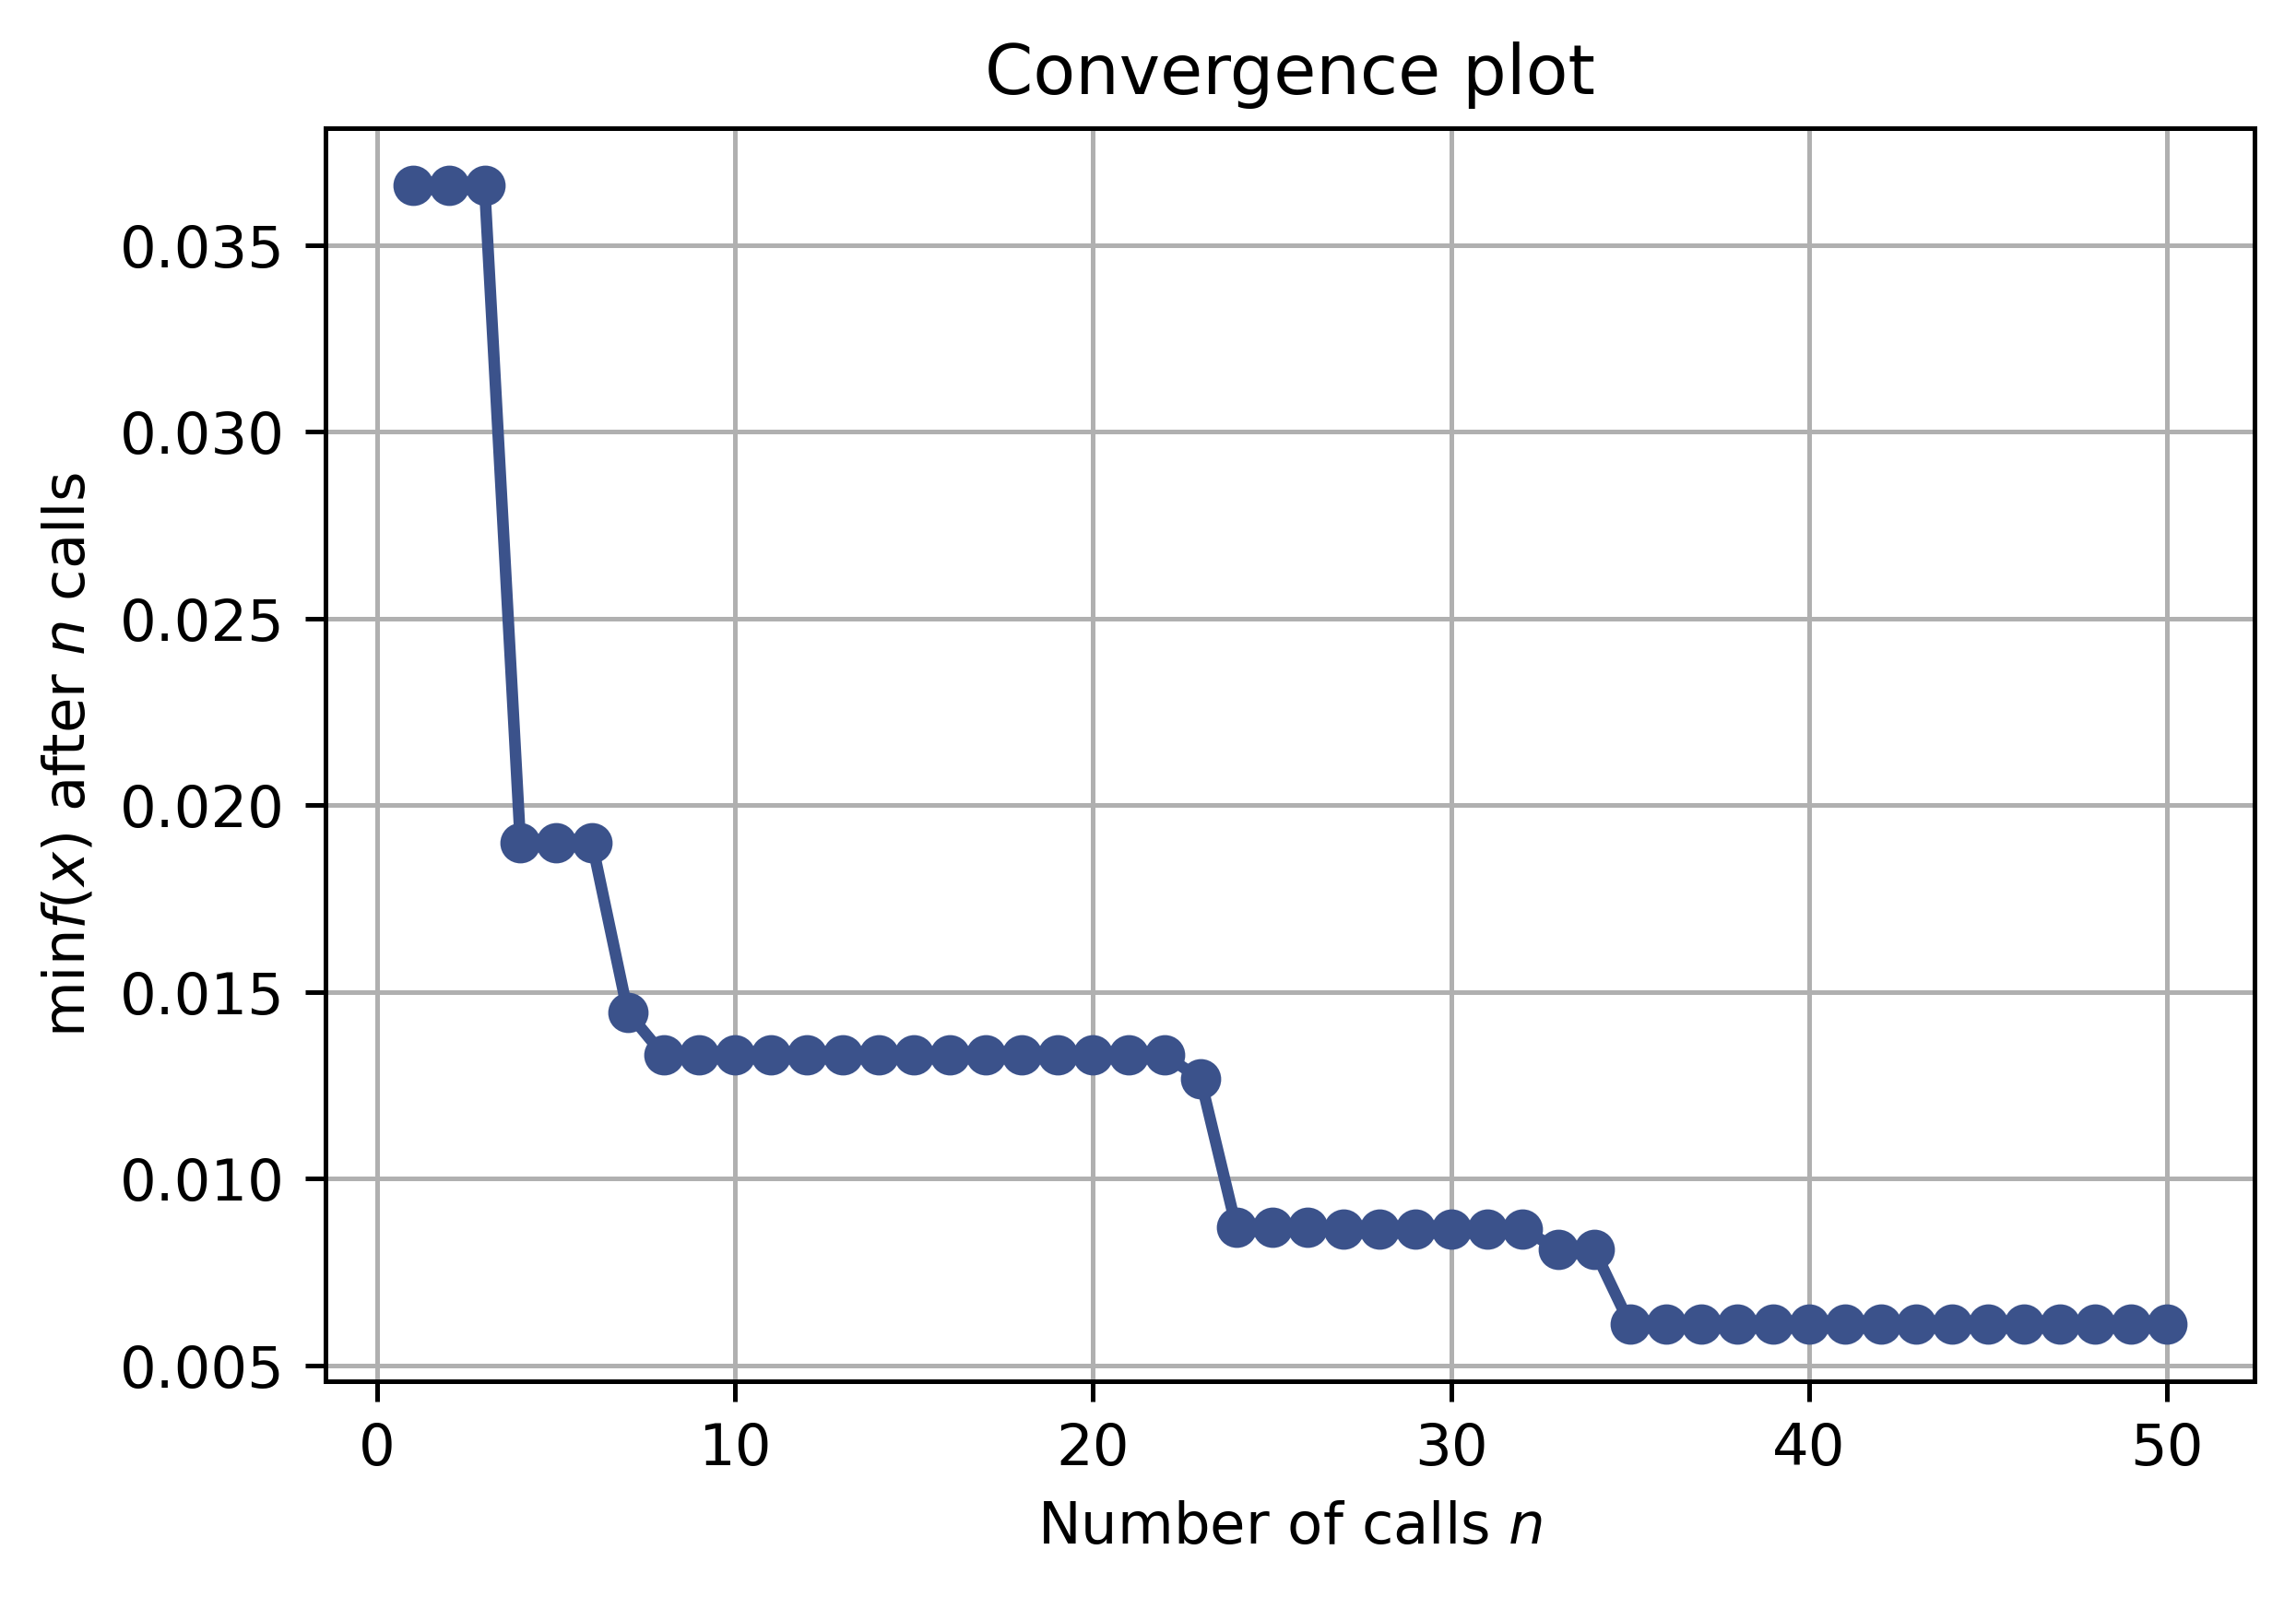

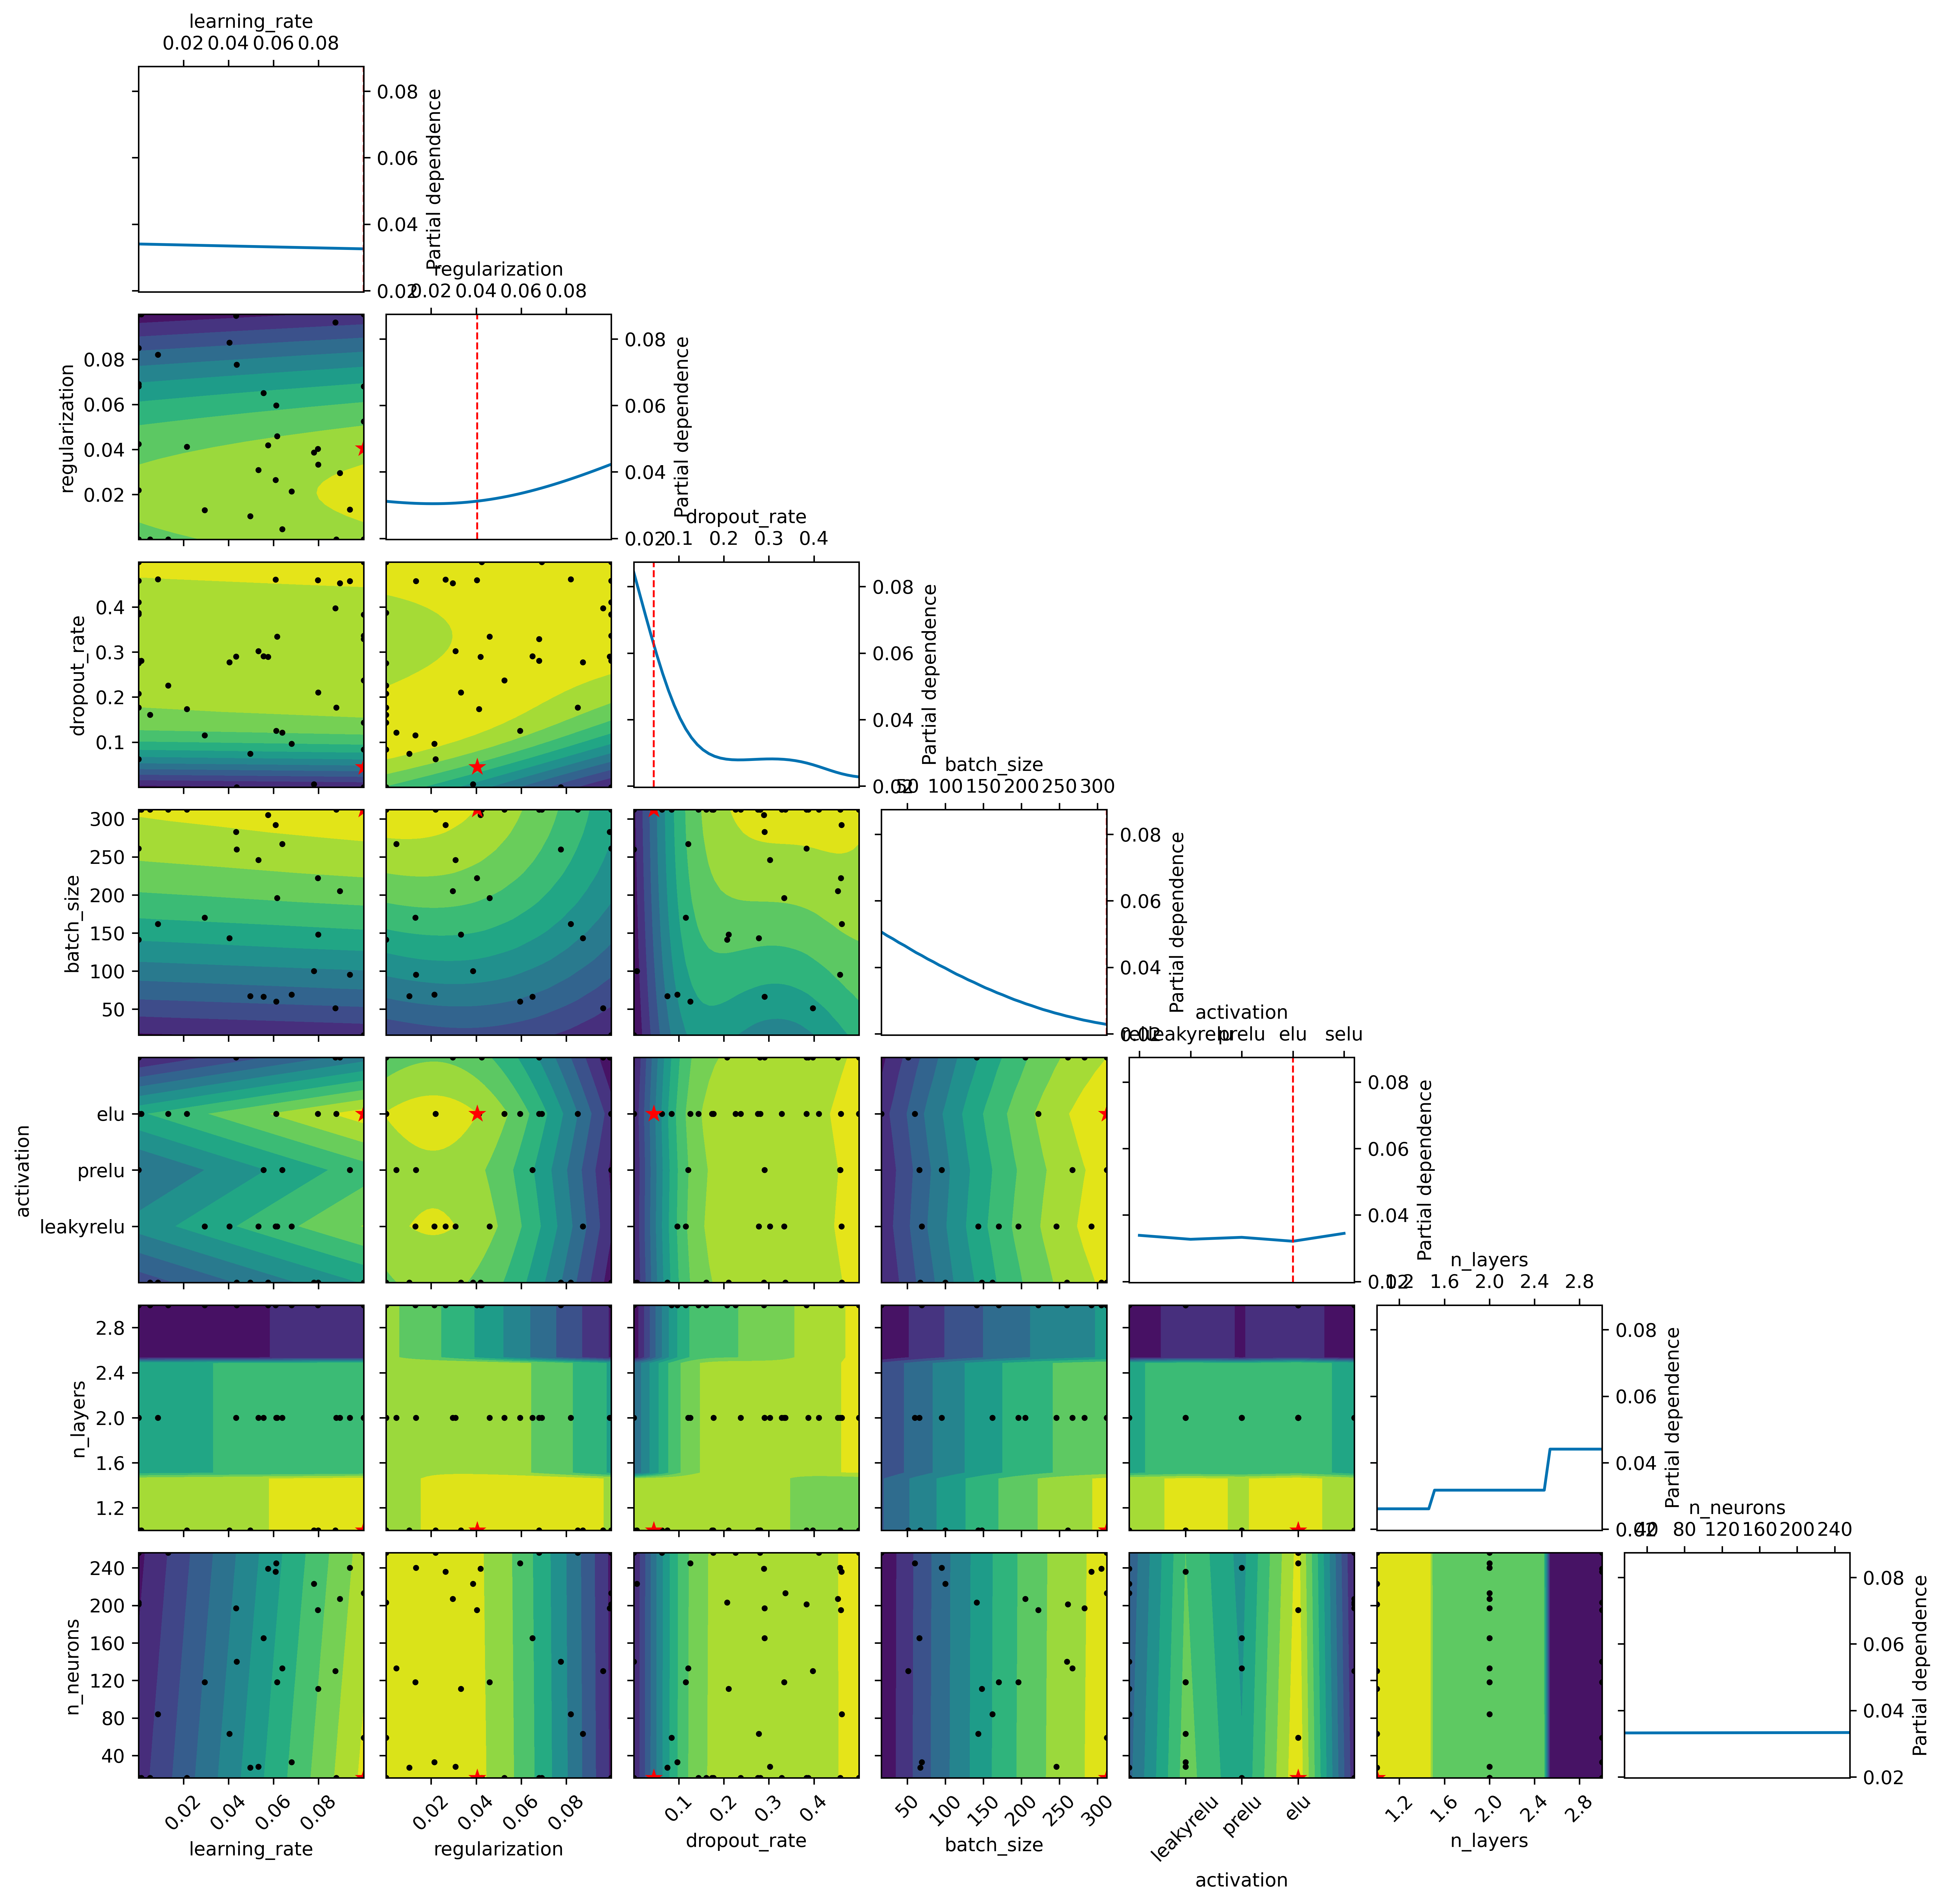

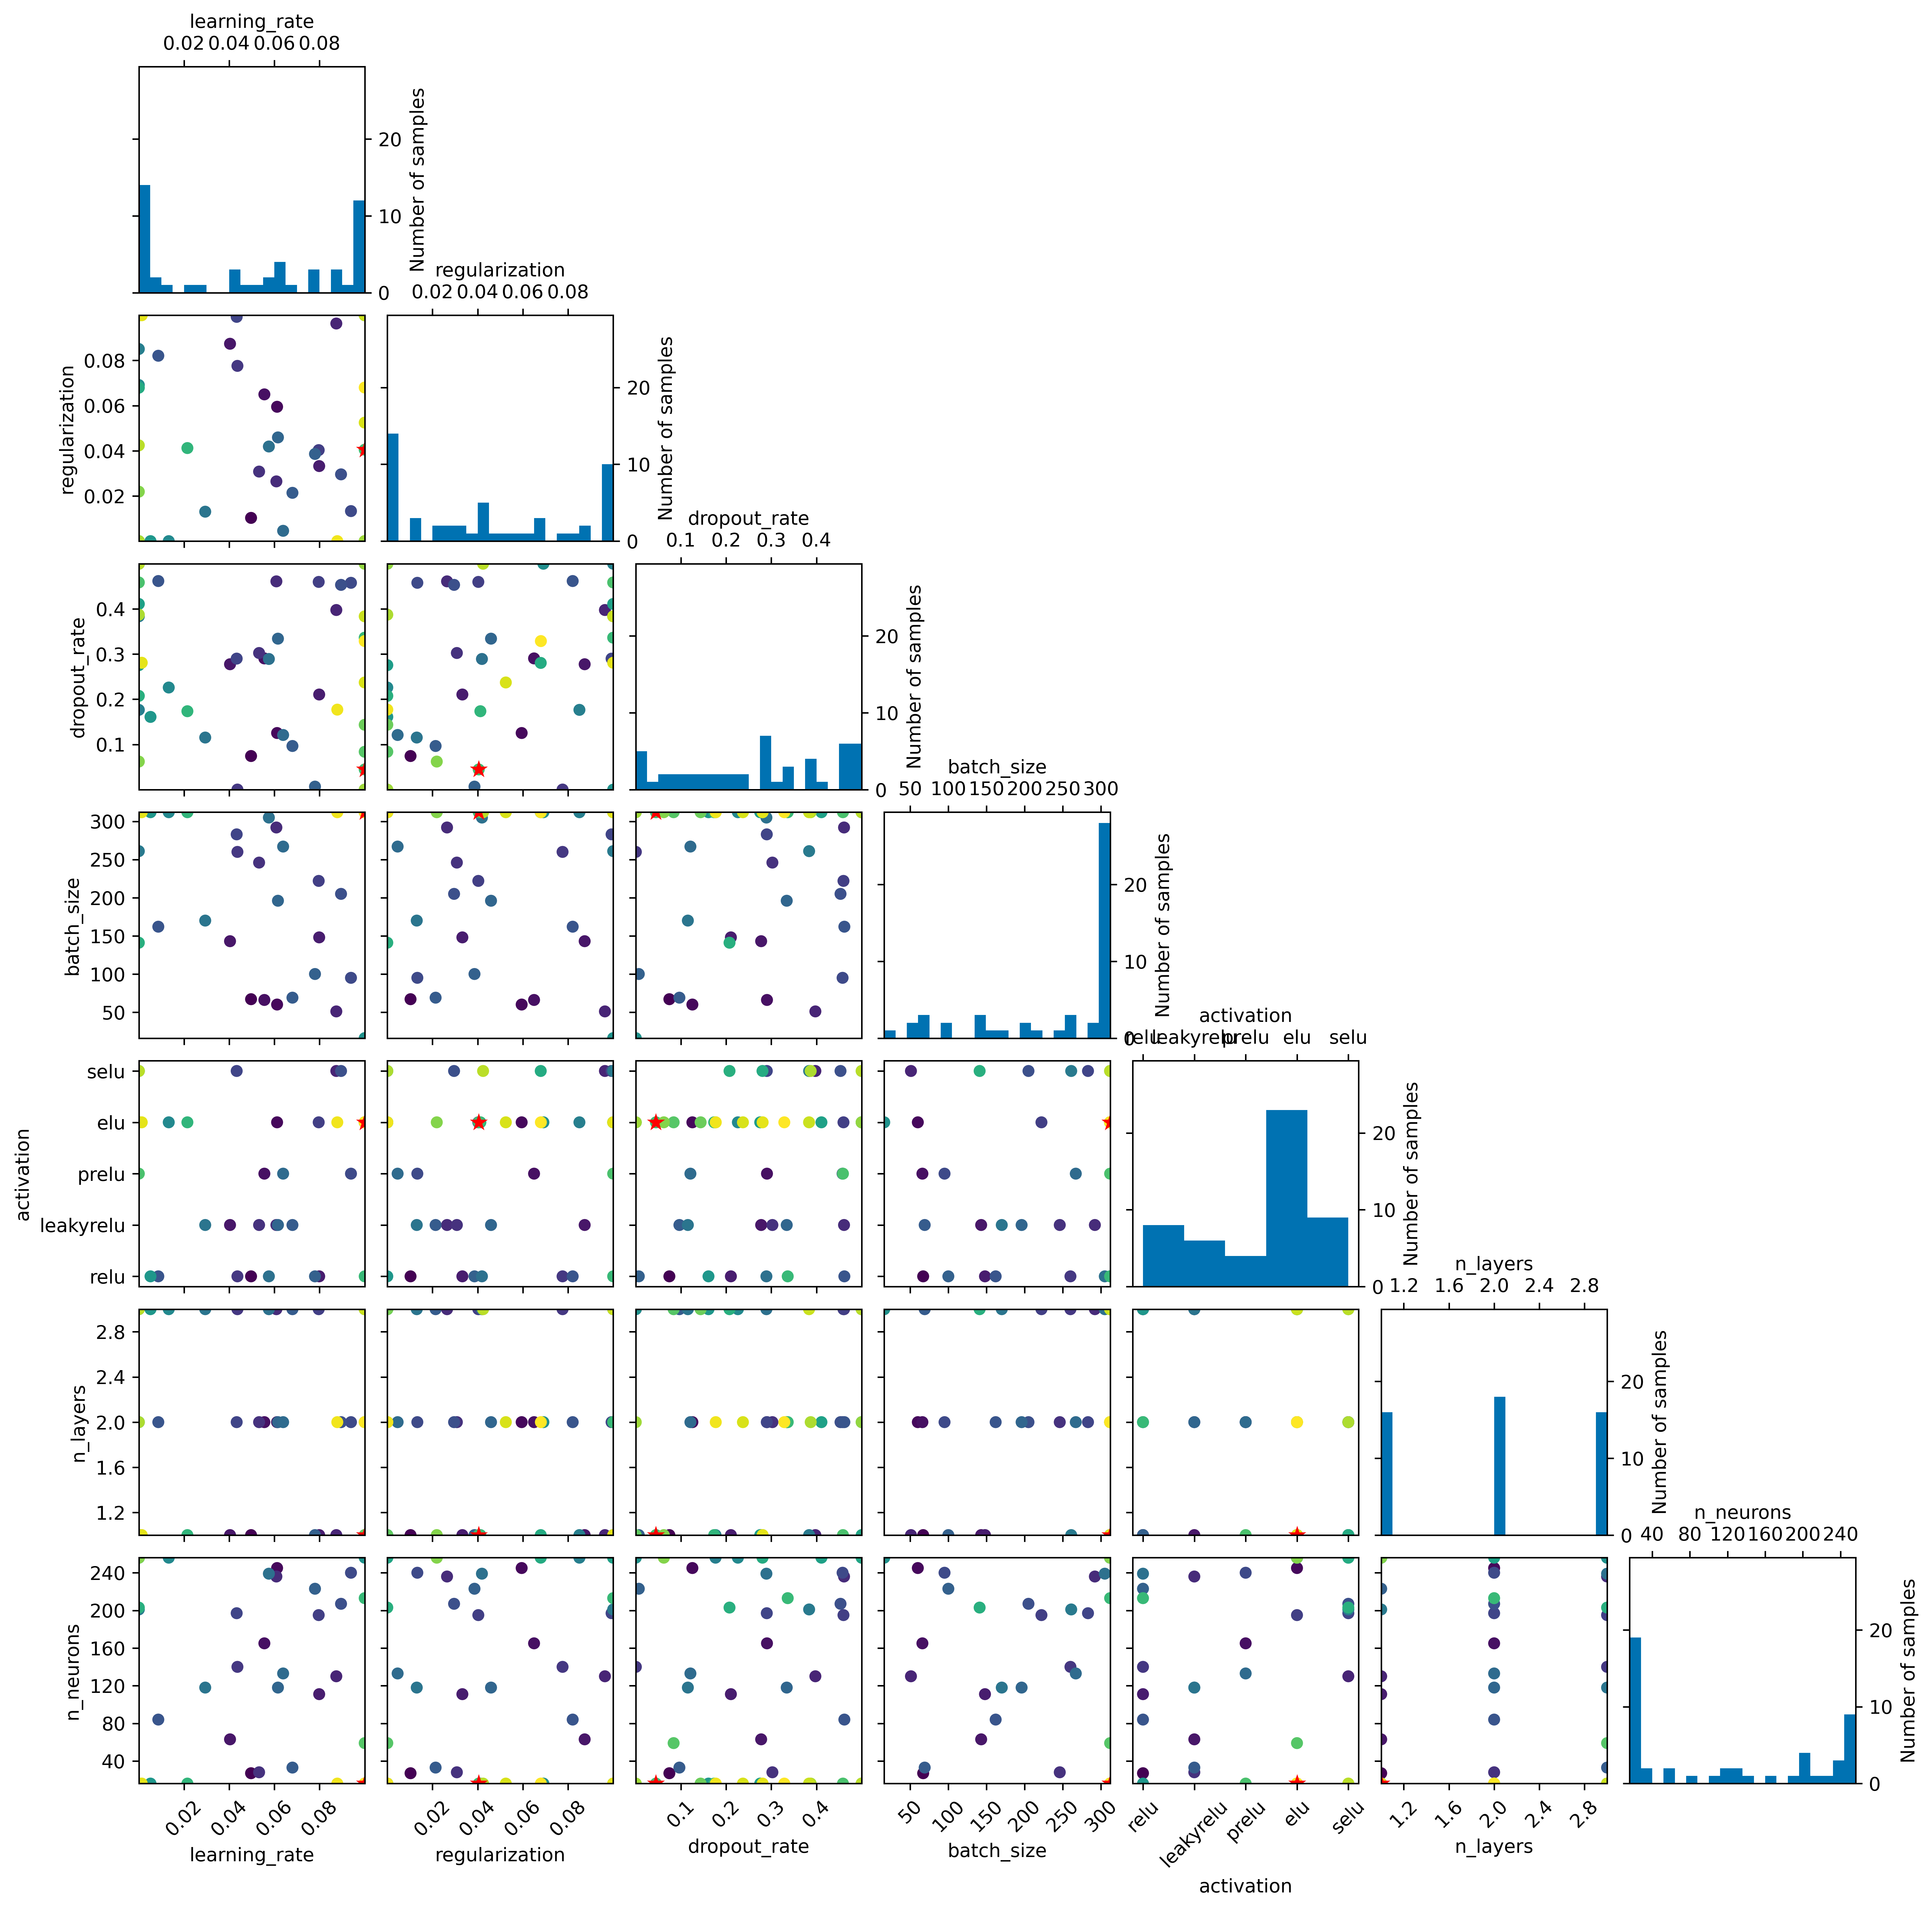

In [26]:
# ------------------- Bayesian optimization --------------------------------- #


class tqdm_skopt(object):
    """Progress bar object for functions with callbacks."""

    def __init__(self, **kwargs):
        self._bar = tqdm(**kwargs)

    def __call__(self, res):
        """Update bar with intermediate results."""
        self._bar.update()


# Set parameter search space
space = []
# space.append(Categorical(['relu', 'leakyrelu', 'elu'], name='activation'))
space.append(Real(1e-5, 1e-1, name='learning_rate'))
space.append(Real(1e-10, 1e-1, name='regularization'))
space.append(Real(0.0, 0.5, name='dropout_rate'))
space.append(Integer(int(16), int(312), name='batch_size', dtype=int))
space.append(Categorical(['relu', 'leakyrelu', 'prelu', 'elu', 'selu'], name='activation'))
space.append(Integer(int(1), int(3), name='n_layers', dtype=int))
space.append(Integer(int(16), int(256), name='n_neurons', dtype=int))

# Set default hyperparameters
default_params = [1e-3,
                  1e-5,
                  0.25,
                  128,
                  'elu',
                  3,
                  128]

# Work in progress
@use_named_args(dimensions=space)
def fitness(learning_rate, regularization, dropout_rate, batch_size, activation,
            n_layers, n_neurons):
    """Perform Bayesian Hyperparameter tuning."""

    if activation == 'relu':
        activation = nn.ReLU()
    elif activation == 'leakyrelu':
        activation = nn.LeakyReLU()
    elif activation == 'elu':
        activation = nn.ELU()
    elif activation == 'selu':
        activation = nn.SELU()
    elif activation == 'prelu':
        activation = nn.PReLU()

    # print(f'Learning Rate: {learning_rate:.0e}, Regularization: {regularization:.0e}, ', end='')
    # print(f'Dropout: {dropout:.2f}')  #, Batch Size: {batch_size}')

    model = NeuralNet(activation=activation, dropout_rate=dropout_rate,
                      n_layers=n_layers, n_neurons=n_neurons)
    model.to(device)
    optimizer = optim.AdamW(model.parameters(), lr=learning_rate,
                                                weight_decay=regularization)
    # Create k-fold cross validation
    avg_best_loss, *_ = kfold_cv_train(x_train=x_train, y_train=y_train,
                                     model=model, optimizer=optimizer,
                                     batch_size=batch_size, patience=100)
    # print(f'Avg. best validation loss: {avg_best_loss}')

    return avg_best_loss

n_calls = 50
# Hyperparemeter search using Gaussian process minimization
gp_result = gp_minimize(func=fitness,
                        dimensions=space,
                        n_calls=n_calls,
                        n_initial_points=20,
                        random_state=SEED,
                        verbose=True, callback=[tqdm_skopt(total=n_calls,
                                          desc='Gaussian Process')])

plot_convergence(gp_result)
plot_objective(gp_result)
plot_evaluations(gp_result)
gp_result.x